[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MariaAise/dl_intro/blob/main/codebook/day1/gemini_image_analyzer.ipynb) 


# Building an Image Analyzer with Gemini API


**Gemini** is a **multimodal large language model**: it consumes and reasons over **non-text signals** (e.g., images, audio, video) *together with text*, and produces **text outputs** (captions, answers, summaries, structured fields). Practically, you pass an image + a prompt, and Gemini returns task-conditioned text.

> *Hint*: currently lots of (formerly) text-only LLM becomes multimodal (GPT model, Grok, DeepSeek, etc.)

At a high level, multimodality is achieved by **mapping non-text inputs into the model’s token/embedding space** and training the Transformer to process **interleaved sequences** of text tokens and **modality tokens**:

* **Modality encoders / tokenizers:** A vision backbone (e.g., ViT-style patch encoder or CNN) converts an image into a sequence of **image embeddings (“image tokens”)**. Similar adapters exist for other modalities.

* **Projection/alignment:** Those image embeddings are **projected** into the same dimensional space as text token embeddings so the **shared Transformer** can attend over both.

* **Joint training objectives:** The model is trained on large **image↔text corpora** (captioning, VQA, OCR-like data, interleaved documents), optimizing **next-token prediction** over sequences that include non-text tokens. This couples language modeling with **cross-modal grounding** (the text it generates must be consistent with visual content).

* **Instruction tuning (multimodal):** Later stages align behavior with user prompts (task formats, reasoning steps, safety), still over interleaved image+text inputs.

Result: the same decoder that predicts the next **text** token now conditions on **image tokens** as context.

---

Let's demonstrate this approach by developing a script that use a **multimodal** variant of Gemini (`MODEL_NAME = "gemini-2.5-flash"`).

- The script allows a user to upload an image and generates analysis.

- We use a **structured prompt** that asks for a consistent, sectioned analysis (caption, perception, style/colour, composition, notable elements).

- Then we convert our script into a shareable application

> *Hint*: this is a startup script that you can extend and develop a tool or incorporate in your research:

* **Tool**: multi-image comparisons, brand/asset QA, visual compliance checks, ad-copy variants grounded in imagery, content moderation with visual evidence.
* **Extraction**: schema-filled JSON (objects, colors, layouts, detected logos), OCR+layout summaries, slide/figure distillation.
* **RAG pipelines**: caption/describe → retrieve related docs → ask grounded questions.
* **Interactive tools**: Gradio/Spaces apps for stakeholders to annotate, triage, or approve outputs.

---


In [ ]:
import io
import os
import mimetypes
from PIL import Image
from IPython.display import display
from google.colab import files, userdata
from google import genai
from google.genai import types

# -----------------------------
# Config
# -----------------------------

# Setting up Gemini API

GEMINI_API_KEY = userdata.get("GEMINI_API_KEY")
if not GEMINI_API_KEY:
    raise ValueError("GEMINI_API_KEY not found in Colab secrets.")

client = genai.Client(api_key=GEMINI_API_KEY)

MODEL_NAME = "gemini-2.5-flash"

# -----------------------------

PROMPT = """
Analyze this image thoroughly and provide a structured response with these exact sections:

**Suggested Caption:** [Create an engaging and descriptive caption]

**Overall Perception:** [Brief overview and general impression]

**Style and Colour:** [Visual style, color palette, lighting]

**Composition:** [Framing, layout, perspective]

**Notable Elements:** [Key objects, people, interesting details]
"""

## Image formats and MIME types

An **image file** is just bytes on disk — 0s and 1s arranged in a way that follows a format specification.

* A **JPEG (.jpg/.jpeg)** encodes pixel data using compression.
* A **PNG (.png)** encodes pixel data + transparency.
* A **WebP (.webp)** is a newer format with smaller file sizes.
* A **HEIC/AVIF** is even newer, designed for high efficiency on phones.

So the *file extension* (`.jpg`, `.png`, `.webp`) is only a **hint** of how the bytes inside should be read.

---

**MIME** = *Multipurpose Internet Mail Extensions*.
It’s a standard way of labeling what kind of content something is, so software knows how to interpret it.

Examples:

* `image/jpeg` → a JPEG photo
* `image/png` → a PNG graphic
* `image/webp` → a WebP image
* `text/plain` → plain text file
* `application/pdf` → PDF document

Think of MIME types as **official labels for file content**.

* **File extension** is user-facing: what you see as `.jpg` or `.png`.
* **MIME type** is machine-facing: what APIs, browsers, and servers use to decide how to handle the bytes.

For example:

* A file named `holiday.jpg` *should* be `image/jpeg`.
* But if someone renamed it to `holiday.png` by mistake, only checking the extension would mislead you. The **MIME type** is safer because it looks at the actual content.

---

* In Colab, when you upload a file, sometimes the **extension gets lost or changed** (e.g. `.webp` becomes `dior_campaign2 (1).webp` or worse just `tmpabcd`).
* The Gemini client requires a **MIME type** when you send an image. If it can’t guess correctly (because of missing extension), you get:

  ```
  ValueError: Unknown mime type
  ```
* That’s why we add a helper: if the type isn’t obvious, we **guess** (with `mimetypes`) or **convert** the image into something universally safe (JPEG).

-----------


Saving image29.jpg to image29.jpg


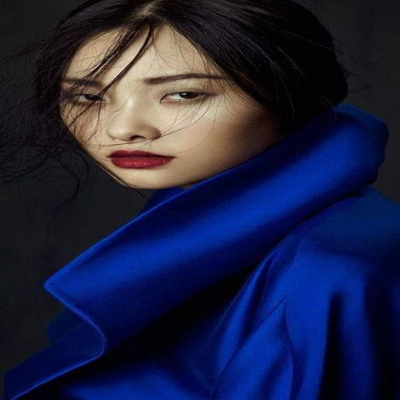

🎯 GEMINI IMAGE ANALYSIS
**Suggested Caption:**
An intense gaze meets a bold statement in royal blue and crimson. This portrait captures a captivating blend of power and allure, where a structured silhouette frames a striking expression against a dramatic backdrop.

**Overall Perception:**
This is a striking and high-impact portrait, likely for fashion or editorial purposes. It conveys a strong sense of drama, sophistication, and intensity. The subject's direct gaze and the vibrant color palette create a captivating visual statement, emphasizing elegance and a powerful presence.

**Style and Colour:**
The style is distinctly high-fashion and editorial, characterized by bold choices in color and expression. The dominant color is a rich, saturated royal blue, which makes up the prominent garment and provides a striking contrast against the model's skin tone and the deep crimson of her lips. The lighting appears to be controlled studio lighting, highlighting the texture of the fabric and t

In [ ]:


# -----------------------------
# Helpers
# -----------------------------


# We create a dictionary to map file extensions to their correct MIME types
# This covers common cases where guessing the type is trivial.

KNOWN_IMAGE_MIMES = {
    ".jpg": "image/jpeg",
    ".jpeg": "image/jpeg",
    ".png": "image/png",
    ".webp": "image/webp",
    ".gif": "image/gif",
}

# These formats are not well-supported by Gemini or by browsers.
# Instead of passing them directly, they are converted into JPEG for reliability.

CONVERT_TO_JPEG_EXTS = {".heic", ".heif", ".avif"}


# We create a function to extract the file extension.
# It looks up the MIME type in the safe dictionary.

def _to_image_part_from_path(filepath: str) -> types.Part:
    ext = os.path.splitext(filepath)[1].lower()
    mime_type = KNOWN_IMAGE_MIMES.get(ext) # we use the dictionary we created earlier to retrieve the value component by providing

    #Fallback MIME type guessing
    if mime_type is None:
        guessed, _ = mimetypes.guess_type(filepath)
        mime_type = guessed


   # Handle problematic or unknown formats
    if ext in CONVERT_TO_JPEG_EXTS or mime_type is None: # If the format is in the “convert” set (HEIC/AVIF) or no MIME type was found:
        img = Image.open(filepath).convert("RGB") # Open the image with Pillow (PIL.Image.open) and convert it to RGB
        buf = io.BytesIO()
        img.save(buf, format="JPEG", quality=95) #Save into an in-memory buffer as JPEG
        buf.seek(0)
        return types.Part.from_bytes(data=buf.read(), mime_type="image/jpeg") #Wrap the JPEG bytes in a types.Part with MIME "image/jpeg".

    # Default path for supported formats
    with open(filepath, "rb") as f:
        return types.Part.from_bytes(data=f.read(), mime_type=mime_type) #For standard formats (JPG, PNG, WebP, etc.), just read raw bytes and wrap them with the correct MIME.

# -----------------------------
# Core function
# -----------------------------
def analyze_image(filepath: str):
    image_part = _to_image_part_from_path(filepath)
    resp = client.models.generate_content(
        model=MODEL_NAME,
        contents=[image_part, PROMPT],
    )
    return resp.text or "_No text response returned._"

# -----------------------------
# Colab flow
# -----------------------------
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# Show preview
display(Image.open(filename).resize((400, 400)))

# Run Gemini
analysis = analyze_image(filename)

print("=" * 70)
print("🎯 GEMINI IMAGE ANALYSIS")
print("=" * 70)
print(analysis)
print("=" * 70)



### Prompt-only vs fine-tuning use

Our code analyses the image using only prompt-only (context engineering) approach which leverages pretrained models without any adjustments to the model itself.

This approach has limitations:

* **Domain drift**: style-specific or brand-specific details may be missed or misnamed.
* **Taxonomy control**: hard to enforce **consistent labels**/schemas across runs.
* **Hallucinations**: model can over-infer attributes not present in the image.
* **Format fidelity**: strict JSON/spec adherence is brittle without constrained decoding or post-validation.
* **OCR/layout edge cases**: small text, non-Latin scripts, dense layouts can degrade.
* **Reproducibility**: sampling variability; requires careful decoding settings (e.g., temperature, top-p) and post-processing.

In some cases such prompt-only approach may not be ideal and you may want to **fune-tune** your model to use:

* **Narrow ontologies**: brand/style vocabularies, product SKUs, internal taxonomies.
* **Consistent structure**: exact JSON schemas, caption tone/voice, compliance phrasing.
* **Specialized OCR**: domain fonts, packaging, receipts, scientific figures.
* **Low-resource visuals**: niche imagery (medical, industrial, satellite) with specific error costs.
* **Quality at scale**: to cut prompt engineering overhead and enforce **deterministic** output patterns.

---

## Converting your code to an app

Google Colab is fantastic for **personal experiments**:

* You can try out models quickly.
* You can tweak code interactively.
* You don’t need to install anything locally.

But the limitations appear when you want to **share your work** with a teammate, a non-technical stakeholder or share results that are buried in logs, print statements, or matplotlib plots.

So if your goal is **collaboration, feedback, or showcasing results**, you need more than just a notebook.

One way to easily solve this problem is using [Gradio](https://www.gradio.app/)

**Gradio** is a Python library that turns your functions (like `def analyze_image(file): …`) into a **web app with a UI** instantly.

* You define inputs (text, image, audio, video, etc.) and outputs (text, plots, images).
* Gradio builds a **browser-based interface** around them automatically.
* You can run it locally, in Colab, or even deploy/share a link with your team.

*Example*: Instead of a Colab cell with `print(response.text)`, you get a webpage with:

* A file upload button
* A preview of the image
* The AI’s structured analysis in a nicely formatted panel

---

Gradio is extremely popular in AI Development:

1. **Low barrier to entry**

   * You don’t need to write HTML, CSS, or JavaScript.
   * Just wrap your Python function.

2. **Rapid prototyping**

   * Perfect for the experimental phase of AI.
   * You can test new model versions in minutes, not weeks.

3. **Support for multimodal inputs**

   * Gradio is designed with AI in mind: image upload, audio recording, webcam, drag-and-drop text — all work out of the box.

4. **Easy sharing**

   * In Colab, `demo.launch(share=True)` instantly gives you a public URL (via Gradio’s servers or Hugging Face Spaces).
   * Your teammates, wherever they are, can open the link and test your app.

5. **Community & ecosystem**

   * It’s widely adopted in AI research and startups.
   * Many Hugging Face Spaces (public AI demos) run on Gradio.
   * This means people already know how to use it, making adoption smoother.

---


## Workflow to convert any script to a Gradio app

1. **Extract a callable (=function)**

   * Wrap your core logic into a function: `def predict(input1, input2, ...): return output`.

2. **Choose I/O components**

   * Your function requires input elements: map each function argument to a Gradio input components (`gr.Textbox`, `gr.Image`, `gr.File`, `gr.Dropdown`, etc.)

   * Your function returns value(s): Map the return(s) to Gradio outputs components (`gr.Textbox`, `gr.Image`, `gr.Audio`, `gr.JSON`, etc.)

3. **Build the interface**

   * Easiest: `gr.Interface(fn=predict, inputs=[...], outputs=[...], title=..., description=...)`

   * For multi-step UIs, use `gr.Blocks()` and wire events (`btn.click(...)`).

4. **Launch & share**

   * Local/Jupyter: `demo.launch()`
   * Colab quick share: `demo.launch(share=True)` → gives you a public URL.
   * Production: push to **Hugging Face Spaces** (Gradio template) or run behind your own server.

5. **Test & iterate**

   * Try edge cases, large files, bad inputs.
   * Add validation, error handling, and helpful messages.



This example below demonstrates a simply gradio app that uses `gr.Interface`

In [ ]:
!pip install -q gradio #install the gradio package first

In [4]:
### Minimal template

import gradio as gr

# 1) Your core logic
def predict(text):
    # do something with `text`
    return text.upper()

# 2) Pick inputs/outputs
inp = gr.Textbox(label="Input text")
out = gr.Textbox(label="Result")

# 3) Build interface
demo = gr.Interface(fn=predict, inputs=inp, outputs=out, title="My App", description="Demo")

# 4) Launch (Colab: share=True for a public link)
demo.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://e4353bb5eecf79d7d2.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


And this example uses `gr.Blocks`: think about this approach as "building with Lego blocks"

In [5]:
import gradio as gr

# Core function
def greet(name):
    return f"Hello, {name}!"

# Build UI with Blocks
with gr.Blocks(title="Minimal Blocks Example") as demo:
    gr.Markdown("## Greeting App")

    with gr.Row():
        name_in = gr.Textbox(label="Enter your name")
        greet_btn = gr.Button("Greet")

    output = gr.Textbox(label="Output")

    # Link button click to function
    greet_btn.click(fn=greet, inputs=name_in, outputs=output)

# Launch
demo.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://aaaa57d5508dfc7d83.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Some commonly used **building blocks** in Gradio `Blocks` apps:
---

## 🧱 Layout Components

These are *containers* that help you arrange your UI.

* **`gr.Blocks`**
  The top-level container for your whole app. Everything lives inside it.
  *Think of it as the “canvas.”*

* **`gr.Row`**
  Places components next to each other horizontally.
  *Use:* Put a Textbox and a Button side-by-side.

* **`gr.Column`**
  Stacks components vertically. Often used inside a `Row`.
  *Use:* Group a label + input box together.

* **`gr.Tab` / `gr.TabItem`**
  Allows multiple tabs in one app, each with its own layout.
  *Use:* When your app has different “modes” (e.g. Image vs Text).

* **`gr.Group`**
  A simple wrapper that groups related components (without forcing row/column layout).
  *Use:* To visually tie related elements together.

---

## 📝 Display / Text Components

For showing static text or rich formatting.

* **`gr.Markdown`**
  Renders Markdown (headings, bullet lists, bold/italic, links, images).
  *Use:* Section headers, instructions, styling.

* **`gr.Label`**
  Displays classification labels (with probabilities if provided).
  *Use:* Model output like “Dog: 95%, Cat: 5%”.

* **`gr.JSON`**
  Displays structured JSON data with collapsible tree view.
  *Use:* API responses, structured results.

---

## 🔤 Input Components

Interactive fields users can fill or adjust.

* **`gr.Textbox`**
  Single-line or multi-line text input.
  *Use:* Prompts, names, free-form input.

* **`gr.Number`**
  Numeric entry (integer/float).
  *Use:* Parameters like learning rate or thresholds.

* **`gr.Slider`**
  Choose a value within a range by dragging.
  *Use:* Control temperature, probability cutoff.

* **`gr.Checkbox` / `gr.CheckboxGroup`**
  Single or multiple true/false choices.
  *Use:* Toggle settings, select categories.

* **`gr.Radio`**
  Pick exactly one option from a list.
  *Use:* Model choice, style selection.

* **`gr.Dropdown`**
  Similar to Radio but as a dropdown menu.
  *Use:* Selecting models, datasets, modes.

* **`gr.File`**
  Upload files (any type).
  *Use:* Feeding CSVs, PDFs, or custom data to your model.

* **`gr.Image`, `gr.Audio`, `gr.Video`**
  Upload or record images/audio/video.
  *Use:* Multimodal AI apps (captioning, speech recognition, etc).

---

## 🎛️ Control Components

Used to trigger or structure interactions.

* **`gr.Button`**
  Click to trigger a function.
  *Use:* Run model, clear results.

* **`gr.Examples`**
  Displays preset examples users can click to auto-fill inputs.
  *Use:* Demo templates, canned inputs.

---

## 📤 Output Components

Show results of your function.

* **`gr.Textbox` (as output)**
  Displays plain text results.

* **`gr.Image` (as output)**
  Shows processed/generated images.

* **`gr.Audio` / `gr.Video`**
  Play results.

* **`gr.HighlightedText`**
  Displays text with spans highlighted.
  *Use:* NLP tasks like named-entity recognition.

---

✅ **How they work together in `Blocks`:**

* Use **layout components** (`Row`, `Column`, `Group`) to arrange things.
* Use **input components** (Textbox, Image, etc.) to collect user data.
* Use **output components** to show results.
* Use **control components** (Button) to connect user actions to your functions.
* Add **display components** (`Markdown`, `Label`) for context and polish.


---

## 🔤 Text Inputs

* **`gr.Textbox`** → Free-form text (single line or multi-line).
  *Use:* Chatbots, prompts, notes, text analysis.
* **`gr.TextArea`** *(alias via Textbox with `lines>1`)* → Long text entry.
  *Use:* Essays, feedback forms.
* **`gr.Dropdown`** → Choose one (or multiple) from a list of options.
  *Use:* Model selector, category choice.
* **`gr.Radio`** → Select exactly one option (radio buttons).
  *Use:* Quick single-choice questions.
* **`gr.Checkbox`** → On/off boolean.
  *Use:* Flags, enable/disable features.
* **`gr.CheckboxGroup`** → Multiple choices from a list.
  *Use:* Select tags, labels, preferences.
* **`gr.Number`** → Numeric input (int or float).
  *Use:* Thresholds, parameters.
* **`gr.Slider`** → Drag to choose a number in a range.
  *Use:* Temperature, probability cutoff, scaling.

---

## 🖼️ Media Inputs

* **`gr.Image`** → Upload or draw an image. Returns PIL image/NumPy array or filepath.
  *Use:* Classification, detection, captioning.
* **`gr.Video`** → Upload or record video. Returns filepath.
  *Use:* Video analysis, action recognition.
* **`gr.Audio`** → Upload or record audio. Returns waveform or filepath.
  *Use:* Speech recognition, emotion detection.
* **`gr.File`** → Upload any file type.
  *Use:* Document analysis, custom file processing.
* **`gr.Dataframe`** → Table entry/edit (like a mini spreadsheet).
  *Use:* Structured input, batch data.

---

## 🎛️ Controls & Special Inputs

* **`gr.Button`** → Trigger actions (not an input to functions directly).
  *Use:* Run, reset, download actions.
* **`gr.ColorPicker`** → Select a color in hex.
  *Use:* Design apps, visualization.
* **`gr.Code`** → Input code with syntax highlighting.
  *Use:* Code execution demos, teaching tools.
* **`gr.JSON`** → Input JSON directly.
  *Use:* Structured API requests.

---

✅ **Rule of thumb**:

* Use **Textbox / Dropdown / Slider** for text & numbers.
* Use **Image / Audio / Video / File** for multimodal AI tasks.
* Use **Checkbox / Radio / Buttons** for toggles & control flow.

---


Now, since we already have a function to analyse images with Gemini, let's convert this script to an app:

In [1]:
import io
import os
import mimetypes
from PIL import Image
import gradio as gr

from google.colab import userdata
from google import genai
from google.genai import types

# -----------------------------
# Config
# -----------------------------
MODEL_NAME = "gemini-2.5-flash"  # or "gemini-2.0-flash"
PROMPT = """
Analyze this image thoroughly and provide a structured response with these exact sections:

**Suggested Caption:** [Create an engaging and descriptive caption]

**Overall Perception:** [Brief overview and general impression]

**Style and Colour:** [Visual style, color palette, lighting]

**Composition:** [Framing, layout, perspective]

**Notable Elements:** [Key objects, people, interesting details]
"""

GEMINI_API_KEY = userdata.get("GEMINI_API_KEY")
if not GEMINI_API_KEY:
    raise ValueError("GEMINI_API_KEY not found in Colab user secrets. Set it in '🔒 Secrets' first.")

client = genai.Client(api_key=GEMINI_API_KEY)

# -----------------------------
# Helpers
# -----------------------------
KNOWN_IMAGE_MIMES = {
    ".jpg": "image/jpeg",
    ".jpeg": "image/jpeg",
    ".png": "image/png",
    ".webp": "image/webp",
    ".gif": "image/gif",
}

# Some formats may not be reliably handled downstream—convert to JPEG when needed
CONVERT_TO_JPEG_EXTS = {".heic", ".heif", ".avif"}  # You can add more if desired

def _to_image_part_from_path(filepath: str) -> types.Part:
    """
    Make a Gemini 'Part' for an image file.
    - Uses the file's bytes and detected mime.
    - Converts certain formats to JPEG if needed (best-effort via Pillow).
    """
    ext = os.path.splitext(filepath)[1].lower()
    mime_type = KNOWN_IMAGE_MIMES.get(ext)
    if mime_type is None:
        # Try to guess from filename
        guessed, _ = mimetypes.guess_type(filepath)
        mime_type = guessed

    # Convert if extension is known-problematic for APIs, or mime is unknown
    if ext in CONVERT_TO_JPEG_EXTS or mime_type is None:
        try:
            img = Image.open(filepath).convert("RGB")
            buf = io.BytesIO()
            img.save(buf, format="JPEG", quality=95)
            buf.seek(0)
            return types.Part.from_bytes(data=buf.read(), mime_type="image/jpeg")
        except Exception as e:
            # Fall back to raw bytes with octet-stream (may fail on API side)
            with open(filepath, "rb") as f:
                data = f.read()
            return types.Part.from_bytes(data=data, mime_type="application/octet-stream")

    # Otherwise, pass through as-is
    with open(filepath, "rb") as f:
        data = f.read()
    return types.Part.from_bytes(data=data, mime_type=mime_type)

# -----------------------------
# Core inference function
# -----------------------------
def analyze_image(file_obj) -> tuple:
    """
    Gradio callback.
    - file_obj is a tempfile-like dict from gr.File (value['name'] is path)
    Returns: (preview_image_path, analysis_markdown)
    """
    if file_obj is None:
        return None, "Please upload an image."

    # gr.File returns a dict-like object in v4; handle both string path and dict path
    filepath = file_obj if isinstance(file_obj, str) else file_obj.get("name")
    if not filepath or not os.path.exists(filepath):
        return None, "Could not read the uploaded file path."

    try:
        image_part = _to_image_part_from_path(filepath)

        # Call Gemini
        resp = client.models.generate_content(
            model=MODEL_NAME,
            contents=[image_part, PROMPT],
        )

        # Use original file as preview; Gradio can display most common formats
        return filepath, (resp.text or "_No text response returned._")

    except Exception as e:
        return filepath, f"**Error:** {e}"

# -----------------------------
# UI
# -----------------------------
with gr.Blocks(title="Gemini Image Understanding (Colab)") as demo:
    gr.Markdown("## Gemini Image Understanding\nUpload a fashion ad (or any image) and get a structured analysis.")

    with gr.Row():
        inp = gr.File(label="Upload an image", file_types=["image"])
    with gr.Row():
        out_img = gr.Image(label="Preview")
        out_md = gr.Markdown(label="Gemini Analysis")

    analyze_btn = gr.Button("Analyze with Gemini", variant="primary")
    analyze_btn.click(analyze_image, inputs=inp, outputs=[out_img, out_md])

    gr.Markdown(
        "Tip: Works with **JPEG/PNG/WebP/GIF**. HEIC/AVIF will be **auto-converted to JPEG** (best-effort)."
    )

# Launch in Colab
demo.launch(share=True, show_api=False, debug=False)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://7780b18762dad8bbf8.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
